In [2]:
import sys, os
sys.path.append("C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/퍼셉트론")  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
import mnist as mnist
import matplotlib.pyplot as plt
from common.trainer import Trainer

### 단순 CNN vs. 복잡한 CNN   

In [4]:
class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1) # y가 예측 값이므로 argmax로 가장 큰 값의 인덱스를 가져온다.
            acc += np.sum(y == tt)   # tt는 정답 레이블이므로 y와 비교하여 같으면 True, 다르면 False가 나온다. True는 1로 취급되므로 sum을 하면 맞춘 개수가 나온다.
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [5]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = mnist.load_mnist(flatten=False)

train loss:2.299463280389267
=== epoch:1, train acc:0.128, test acc:0.126 ===
train loss:2.2989614768409594
train loss:2.2936797878154316
train loss:2.286135772192152
train loss:2.285675575674831
train loss:2.269435246314802
train loss:2.245600252637436
train loss:2.2295067774308874
train loss:2.2082421950589315
train loss:2.197246650089114
train loss:2.14894303553277
train loss:2.144443170692122
train loss:2.1563659311562784
train loss:2.0469411599859115
train loss:1.963214852002711
train loss:1.991917895612214
train loss:1.9162850761837538
train loss:1.8424210842196813
train loss:1.7631559038421207
train loss:1.8013407672749127
train loss:1.7164697395783874
train loss:1.5693093947254297
train loss:1.4829975153359825
train loss:1.3191407416156387
train loss:1.339843556273409
train loss:1.2360654580387527
train loss:1.3033741232222218
train loss:1.083773908450147
train loss:1.0397156232057556
train loss:1.0911749360428629
train loss:0.9803058639182726
train loss:0.906700693998136
train

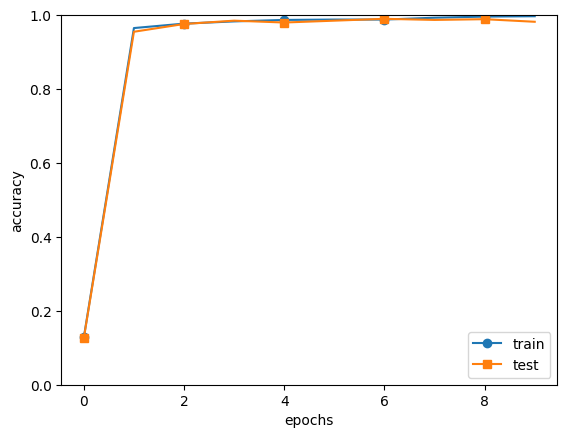

In [6]:
max_epochs = 10

# 커널 개수: 30, 커널 사이즈: 5x5, 커널 스트라이드: 1 
# FC-Layer 노드 개수: 100
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
         
# 에폭 수: 10, 미니배치 사이즈: 100, 최적화기법: Adam(Ir: 0.001) 
# 매 에폭 시 평가에 사용되는 샘플 수: 1000              
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

# trainer 클래스의 train 함수 호출
# train 함수는 epochs만큼 반복하면서 미니배치 학습을 수행한다.
# 매 에폭마다 평가 데이터를 사용하여 정확도를 측정
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# test 데이터 정확도 리스트 저장
simple_conv_net_result = trainer.test_acc_list

# # 그래프 그리기
# markers = {'train': 'o', 'test': 's'}
# x = np.arange(max_epochs)
# # 학습 데이터 정확도 결과 
# plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
# # 평가 데이터 정확도 결과 
# plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
# plt.xlabel("epochs")
# plt.ylabel("accuracy")
# plt.ylim(0, 1.0)
# plt.legend(loc='lower right')
# plt.show()

In [9]:
class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망

    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 # Convolution Layer
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1}, # 커널 개수: 16, 커널 사이즈: 3x3, 커널 스트라이드: 1
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1}, # 커널 개수: 16, 커널 사이즈: 3x3, 커널 스트라이드: 1
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1}, # 커널 개수: 32, 커널 사이즈: 3x3, 커널 스트라이드: 1
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1}, # 커널 개수: 32, 커널 사이즈: 3x3, 커널 스트라이드: 1
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1}, # 커널 개수: 64, 커널 사이즈: 3x3, 커널 스트라이드: 1
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1}, # 커널 개수: 64, 커널 사이즈: 3x3, 커널 스트라이드: 1
                 hidden_size=50, output_size=10):                                        # FC-Layer 노드 개수: 50
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        # Conv-Relu
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        # Conv-Relu-Pooling
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        # Conv-Relu
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        # Conv-Relu-Pooling
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        # Conv-Relu
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5)) # Dropout 50%
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5)) # Dropout 50%
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

In [10]:
# 데이터 로드 
# 학습 데이터: x_train, t_train, 평가 데이터: x_test, t_test
(x_train, t_train), (x_test, t_test) = mnist.load_mnist(flatten=False)

network = DeepConvNet()  

# 에폭 수: 10, 미니배치 사이즈: 100, 최적화기법: Adam(Ir: 0.001) 
# 매 에폭 시 평가에 사용되는 샘플 수: 1000   
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=10, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)

# Trainer 클래스 train 함수 호출  
trainer.train()

# test 데이터 정확도 리스트 저장
deep_layered_conv_net_result = trainer.test_acc_list

# 매개변수 보관
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")

train loss:2.2640569649142885
=== epoch:1, train acc:0.084, test acc:0.088 ===
train loss:2.304892568350864
train loss:2.2857807896456834
train loss:2.270851313554969
train loss:2.2769513760058984
train loss:2.284779451402149
train loss:2.290203937858655
train loss:2.296548057866648
train loss:2.2959342613762543
train loss:2.2490837961003103
train loss:2.2732773960255885
train loss:2.250910774062492
train loss:2.220450276751299
train loss:2.244941881438421
train loss:2.183869996005701
train loss:2.2306720330927696
train loss:2.206342129746011
train loss:2.1877206579006967
train loss:2.137342794134327
train loss:2.1702146085571012
train loss:2.118814613551667
train loss:2.157619832659704
train loss:2.0605234331142204
train loss:2.148711398376527
train loss:2.0772220215001935
train loss:1.937778330912698
train loss:2.032039247027345
train loss:2.0028685444481447
train loss:2.1813196076961328
train loss:2.04824608915208
train loss:2.0375512512826606
train loss:1.9344359403020783
train los

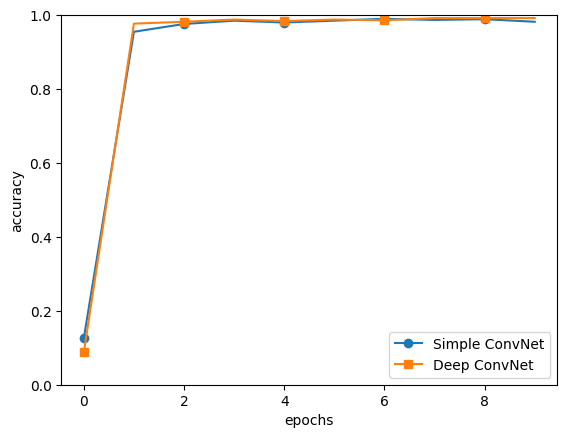

In [14]:
# Simple CNN, DeepLayered CNN 정확도 비교 그래프
x = np.arange(max_epochs)
plt.plot(x, simple_conv_net_result, marker='o', label='Simple ConvNet', markevery=2)
plt.plot(x, deep_layered_conv_net_result, marker='s', label='Deep ConvNet', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### Convolution, Pooling 층을 하나 더 늘렸다. 

In [15]:
class ConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1}, # filter_num: 필터 수, filter_size: 필터 크기, pad: 패딩, stride: 스트라이드
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) // filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(filter_num, filter_num, filter_size, filter_size)
        self.params['b2'] = np.zeros(filter_num)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu2'] = Relu()
        self.layers['Pool2'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W4'], self.params['b4'])

        self.last_layer = SoftmaxWithLoss()   # 출력층

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W3'], grads['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W4'], grads['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [18]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = mnist.load_mnist(flatten=False)

In [20]:
max_epochs = 10 

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 10, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=50, output_size=10, weight_init_std=0.01)

# 에폭 수: 10, 미니배치 사이즈: 100, 최적화기법: Adam(Ir: 0.001) 
# 평가 시 사용되는 샘플 수: 1000                         
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=16,
                  optimizer='SGD', optimizer_param={'lr': 0.01},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

train loss:2.301768735863214
=== epoch:1, train acc:0.115, test acc:0.125 ===
train loss:2.301434872208837
train loss:2.3023362277382597
train loss:2.3020020564546657
train loss:2.302635702935197
train loss:2.301777888830582
train loss:2.302057188590069
train loss:2.3023726768877517
train loss:2.3028244411978984
train loss:2.3026815636208227
train loss:2.3017038835077517
train loss:2.3022424248949713
train loss:2.302327447827497
train loss:2.3025167797414428
train loss:2.301678171765047
train loss:2.302536713291569
train loss:2.3018622368318784
train loss:2.3016719328622335
train loss:2.301218058028245
train loss:2.302940699353775
train loss:2.301144457125731
train loss:2.300344730780859
train loss:2.3013347199754204
train loss:2.2987714530755787
train loss:2.3039607200627925
train loss:2.301171202532858
train loss:2.302113183671006
train loss:2.3024882489320664
train loss:2.299119266631311
train loss:2.3002439302152946
train loss:2.303765107730723
train loss:2.301664514641411
train lo

In [ ]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 심층 신경망 VS. CNN 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# MNIST data 데이터 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True) # 배치 사이즈 128
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)  # 배치 사이즈 128

Failed to download (trying next):
<urlopen error [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다>



100%|██████████| 9912422/9912422 [00:26<00:00, 375037.80it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다>



100%|██████████| 28881/28881 [00:00<00:00, 153458.70it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다>



100%|██████████| 1648877/1648877 [00:03<00:00, 498474.20it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다>



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
# Define a general deep neural network
# FC-Layer가 3개인 MLP, 은닉층 노드 수: 512개, 활성화 함수: ReLU
class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.flatten = nn.Flatten()
        # FC-Layer
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        # 출력층
        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define a convolutional neural network
# Convolutional layer 2개, Fully connected layer 1개, 활성화 함수: ReLU, Max pooling 사용
class CNN(nn.Module):
    # Conv - ReLU - Conv - ReLU - Pool - FC - ReLU - FC
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)   # 커널 개수: 32, 커널 크기: 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 커널 개수: 64, 커널 크기: 3x3
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)                            # 64개의 14x14 이미지        
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train and evaluate function
def train_and_evaluate(model, epochs=5):                                    # epochs: 5
    criterion = nn.CrossEntropyLoss()                                       # 손실 함수: CrossEntropy 
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)        # optimizer: SGD, learning rate: 0.01, momentum: 0.0
    
    train_accuracy = []
    val_accuracy = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            # loss 계산
            loss = criterion(outputs, labels)
            # 역전파
            loss.backward()
            # 가중치 기울기 갱신 
            optimizer.step()
            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy.append(correct / total)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                # 정확도 계산
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy.append(correct / total)
        
    # train, test 데이터에 대한 정확도 반환 
    return train_accuracy, val_accuracy

In [4]:
# Instantiate models
deep_nn = DeepNN()
cnn = CNN()

In [5]:
# Train and evaluate both models
print("Training Deep Neural Network...")
deep_nn_train_acc, deep_nn_val_acc = train_and_evaluate(deep_nn)

print("Training Convolutional Neural Network...")
cnn_train_acc, cnn_val_acc = train_and_evaluate(cnn)

Training Deep Neural Network...
Training Convolutional Neural Network...


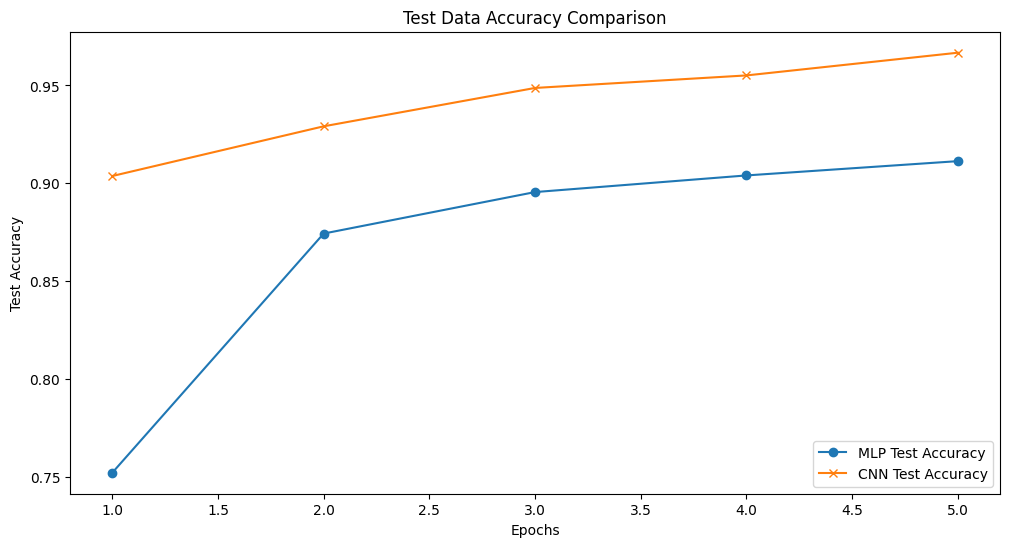

In [7]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot DeepNN
plt.plot(range(1, 6), deep_nn_val_acc, label="MLP Test Accuracy", marker='o')

# Plot CNN
plt.plot(range(1, 6), cnn_val_acc, label="CNN Test Accuracy", marker='x')

plt.title("Test Data Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

